In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import time

%matplotlib inline 

#TODO : CHANGE ACCORDING TO NEEDS
imported_data=True # True if data/... already exists
evaluation=True # True if want to evaluate error of machine learning algo
submit=True # True if want to replace submission file by new values

In [2]:
#Import data if not already done
if (not imported_data) : 
    import ImportData

In [3]:
# BEGINNING OF LEARNING CODE
# Read submission data
submission = pd.read_csv('submission.txt', sep='\t')

# Stock list of services to predict
ass_list=submission['ASS_ASSIGNMENT'].unique()

# Imports data into dictionary
data = {}
for x in ass_list : 
    data[x] = np.load('data/'+x+'.npy')

In [4]:
#Adding features

# add_features() changes structure of data[x] where x is a service name :
# date (timestamp) / number of calls / day of week / month / time
# time is from 0 to 47 (hour*2+minutes/30)
def add_features(): 
    for x in ass_list :
        # Initialize two columns of zero
        n=np.shape(data[x])[0]
        z=np.zeros((n,3),int) 
        
        # Append zero column twice
        data[x]=np.append(data[x],z,axis=1)

        # Addding Columns : Day of week / Month
        for i in range(n) :
            data[x][i,2]=pd.to_datetime(data[x][i,0]).weekday()
            data[x][i,3]=data[x][i,0].month
            data[x][i,4]=int((2*data[x][i,0].hour)+(data[x][i,0].minute/30))
            
        print("Features added for "+x)
        # TODO IMPROVE
        # - possibly much faster if adding features in dataframe
        # - Label Binarizer - change magnitude of day of week, month, hour
        #                     to 7, 31, 48 columns of 0 and 1s respectively
        
# del_features deletes everything from column 2
def del_features():
    for x in ass_list :
        data[x]=np.delete(data[x],np.s_[2:np.shape(data[x])[1]],1)
        
del_features()
add_features()
print(data[ass_list[0]][::1000,:])

Features added for CMS
Features added for Crises
Features added for Domicile
Features added for Gestion
Features added for Gestion - Accueil Telephonique
Features added for Gestion Assurances
Features added for Gestion Relation Clienteles
Features added for Gestion Renault
Features added for Japon
Features added for Médical
Features added for Nuit
Features added for RENAULT
Features added for Regulation Medicale
Features added for SAP
Features added for Services
Features added for Tech. Axa
Features added for Tech. Inter
Features added for Téléphonie
Features added for Tech. Total
Features added for Mécanicien
Features added for CAT
Features added for Manager
Features added for Gestion Clients
Features added for Gestion DZ
Features added for RTC
Features added for Prestataires
[[Timestamp('2011-01-13 00:00:00') 0 3 1 0]
 [Timestamp('2011-04-13 12:30:00') 0 2 4 25]
 [Timestamp('2011-01-15 23:30:00') 0 5 1 47]
 [Timestamp('2011-07-15 13:00:00') 0 4 7 26]
 [Timestamp('2011-07-06 20:30:00'

In [10]:
# data is ambient dictionary in this script

# predict takes in "dates" which is a list of timestamps (continuous)
# predict returns a dictionary predicted where:
# keys = services, values = numpy arrays (TimeStamp, Calls Received)

# predict contains a machine learning algorithm that does : 
# 1. Preprocessing - feature reduction + engineering features if necessary
# 2. Learning - regression, random forest, neural network, etc.


def predict(dates) : 
    # Initialize and clear dictionary to return
    predicted={}
    predicted.clear()
    z=np.zeros((len(dates),1))

    for x in ass_list : 
        predicted[x]=np.append(np.reshape(dates,(len(dates),1)),z,axis=1)

    # Take minimum of dates
    min_date = min(dates)

    # Take average of calls at particular time and add half variance
    values={}
    
    # Pass to dataframe for faster calculation of mean and variance by hour
    for x in ass_list : 
        print("Calculations for "+x)
        df=pd.DataFrame(data[x])
        df.columns=["Timestamp","Calls","Weekday","Month","Hour"]
        ave = np.empty(48)
        var = np.empty(48)
        
        for i in range(48) : 
            ave[i]=(df['Calls'][df['Hour']==i].mean())
            var[i]=(df['Calls'][df['Hour']==i].var())
        
        # var/2 chosen arbitrarily : TODO, tune this
        values[x]=(np.ceil(ave+np.sqrt(var)/2)).astype(int)
        
        # Insert into predicted dictionary
        for i in range(len(dates)):
            predicted[x][i,1]=values[x][(predicted[x][i,0].hour+predicted[x][i,0].minute/30)]

    return predicted
'''
dates=[datetime.strptime('2011-12-28 00:00:00.000', "%Y-%m-%d %H:%M:%S.%f"),
       datetime.strptime('2011-12-28 00:30:00.000', "%Y-%m-%d %H:%M:%S.%f"),
       datetime.strptime('2011-12-28 01:00:00.000', "%Y-%m-%d %H:%M:%S.%f")]
#predicted = predict(dates)


for x in ass_list : 
    print("Predictions for "+x)
    print(predicted[x])
    print("Real values for "+x)
    for i in range(len(data[x])) : # iterate through data of service
        for j in range(len(dates)) : # iterate through dates
            if (data[x][i,0]==dates[j]) : # if good date
                print(data[x][i,:2])
    print()
'''

'\ndates=[datetime.strptime(\'2011-12-28 00:00:00.000\', "%Y-%m-%d %H:%M:%S.%f"),\n       datetime.strptime(\'2011-12-28 00:30:00.000\', "%Y-%m-%d %H:%M:%S.%f"),\n       datetime.strptime(\'2011-12-28 01:00:00.000\', "%Y-%m-%d %H:%M:%S.%f")]\n#predicted = predict(dates)\n\n\nfor x in ass_list : \n    print("Predictions for "+x)\n    print(predicted[x])\n    print("Real values for "+x)\n    for i in range(len(data[x])) : # iterate through data of service\n        for j in range(len(dates)) : # iterate through dates\n            if (data[x][i,0]==dates[j]) : # if good date\n                print(data[x][i,:2])\n    print()\n'

In [9]:
# Function dates_to_datetime creates datetime stamps at every half hour from a list of date
def dates_to_datetime(dates) : 
    datetimes=[]
    times=["00:00:00.000", "00:30:00.000", "01:00:00.000", "01:30:00.000", 
           "02:00:00.000", "02:30:00.000", "03:00:00.000", "03:30:00.000", 
           "04:00:00.000", "04:30:00.000", "05:00:00.000", "05:30:00.000", 
           "06:00:00.000", "06:30:00.000", "07:00:00.000", "07:30:00.000", 
           "08:00:00.000", "08:30:00.000", "09:00:00.000", "09:30:00.000", 
           "10:00:00.000", "10:30:00.000", "11:00:00.000", "11:30:00.000", 
           "12:00:00.000", "12:30:00.000", "13:00:00.000", "13:30:00.000", 
           "14:00:00.000", "14:30:00.000", "15:00:00.000", "15:30:00.000", 
           "16:00:00.000", "16:30:00.000", "17:00:00.000", "17:30:00.000", 
           "18:00:00.000", "18:30:00.000", "19:00:00.000", "19:30:00.000", 
           "20:00:00.000", "20:30:00.000", "21:00:00.000", "21:30:00.000", 
           "22:00:00.000", "22:30:00.000", "23:00:00.000", "23:30:00.000"]
    for date in dates : 
        for time in times : 
            datetime_entry=str(date+' '+time)
            datetimes.append(datetime.strptime(datetime_entry, "%Y-%m-%d %H:%M:%S.%f"),)
    return datetimes

# Error function as defined in project
def linex(y_true,y_pred) : 
    a=0.1
    assert(len(y_true)==len(y_pred))
    diff=np.subtract(y_true,y_pred)
    return np.exp(a*diff)-a*diff-np.ones(len(y_true))


#EVALUATION
if (evaluation) : 
    # EXAMPLE DATE
    dates = ['2011-12-28', '2011-12-29', '2011-12-30', '2011-12-31', '2012-01-01', '2012-01-02', '2012-01-03']
    fulldates=dates_to_datetime(dates) #with timestamps, for predict function
    
    # Call predict
    predicted=predict(fulldates)

    # Dictionaries for true and predicted values
    y_true={}
    y_pred={}
    y_true.clear()
    y_pred.clear()
    err={}
    err.clear()
    err_tot=0
    len_tot=0
    
    # Stocking and printing error by service where there is data
    for x in ass_list : 
        y_true[x]=[]
        y_pred[x]=[]
        print("Evaluating error for : "+x)
        for t in fulldates : # for date
            for i in range(len(data[x])) : 
                if (data[x][i,0]==t) : # if date found in original data
                    y_true[x].append(data[x][i,1])
                    for j in range(len(predicted[x])) : #find date in predicted
                        if (str(predicted[x][j,0])==str(t)) : 
                            y_pred[x].append(predicted[x][j,1])
                            break # add predicted one time
                    break # add original one time
        err[x]=linex(y_true[x],y_pred[x])
        err_tot+=np.sum(err[x])
        len_tot+=len(err[x])
        #print("vector error : ")
        #print(err[x])
        print("error : ")
        print(np.sum(err[x]))
        print()
    print("total error : ")
    print(err_tot)

Calculations for CMS
Calculations for Crises


/home/yujia21/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Calculations for Domicile
Calculations for Gestion
Calculations for Gestion - Accueil Telephonique
Calculations for Gestion Assurances
Calculations for Gestion Relation Clienteles
Calculations for Gestion Renault
Calculations for Japon
Calculations for Médical
Calculations for Nuit
Calculations for RENAULT
Calculations for Regulation Medicale
Calculations for SAP
Calculations for Services
Calculations for Tech. Axa
Calculations for Tech. Inter
Calculations for Téléphonie
Calculations for Tech. Total
Calculations for Mécanicien
Calculations for CAT
Calculations for Manager
Calculations for Gestion Clients
Calculations for Gestion DZ
Calculations for RTC
Calculations for Prestataires
Evaluating error for : CMS
error : 
0.145122541079

Evaluating error for : Crises
error : 
0.362806352697

Evaluating error for : Domicile
error : 
500.259803813

Evaluating error for : Gestion
error : 
0.575652746279

Evaluating error for : Gestion - Accueil Telephonique
error : 
25.9084289294

Evaluating e

In [11]:
# UPDATE SUBMISSIONS.TXT
# ASS_ASSIGNMENT : because not every service appears at any time, 
# have to check values exist in submissions.txt that we received,
# we cannot construct new dataframe directly from predicted

if (submit) : 
    # List of dates in submission.txt file
    dates=[]
    for date in submission['DATE'].unique() : 
        dates.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f"))
    
    # Call predict function
    predicted=predict(dates)
    
    #Rewrite submissions dataframe
    for x in ass_list : 
        print("Stocking predictions for "+x)
        if (x in predicted) : # x=assignment
            for row in predicted[x] : # row=[date,calls]
                # Convert timestamp to yyyy-mm-dd hh:mm:ss.xxx
                date = row[0].strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]
                submission.loc[(submission['DATE']==date)&(submission['ASS_ASSIGNMENT']==x), ['prediction']]=row[1]

                #better way to loop through this?
    # EXPORT to submission.txt : problem with \t delimiter on online submission ? TODO
    np.savetxt('submission1.txt',submission.values, comments='', header='DATE\tASS_ASSIGNMENT\tprediction', delimiter='    ', fmt='%s %s %d')
    
    fh = open("submission2.txt","w")
    fh.write("DATE\tASS_ASSIGNMENT\tprediction")
    for index, row in submission.iterrows(): 
        fh.write("\n")
        fh.write(str(row[0])+'\t'+str(row[1])+'\t'+str(row[2]))
    fh.close()
    print("Text file written!")

Calculations for CMS


IndexError: invalid index to scalar variable.

CMS


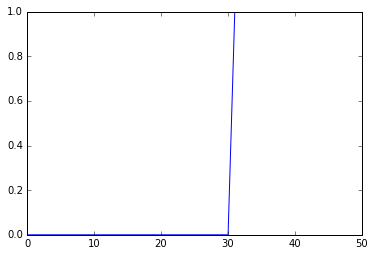

Crises


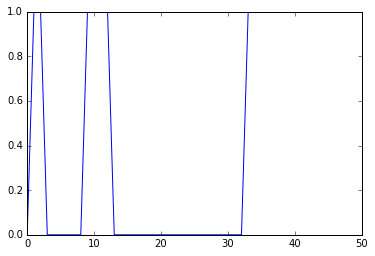

Domicile


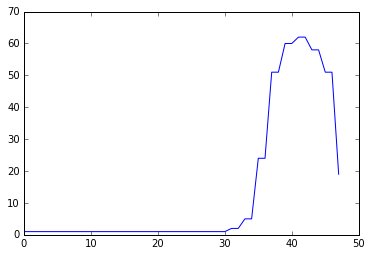

Gestion


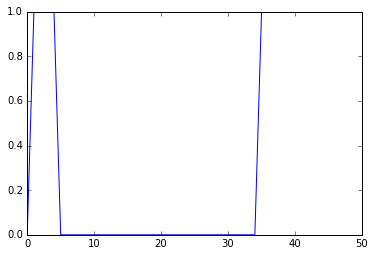

Gestion - Accueil Telephonique


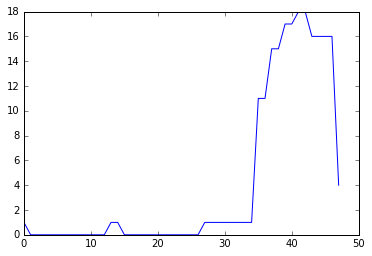

Gestion Assurances


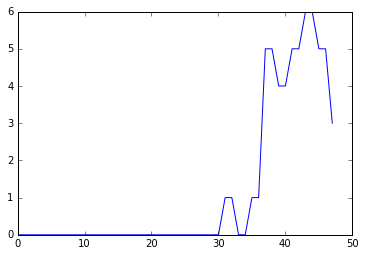

Gestion Relation Clienteles


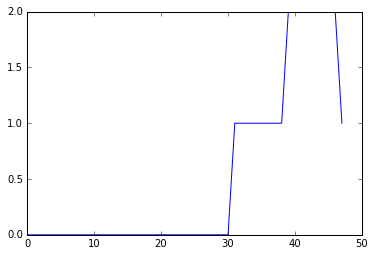

Gestion Renault


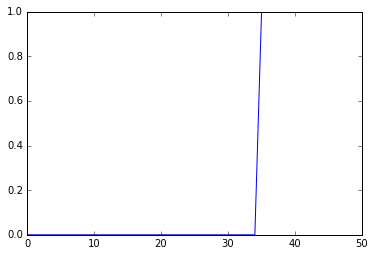

Japon


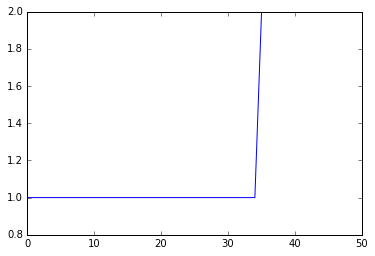

Médical


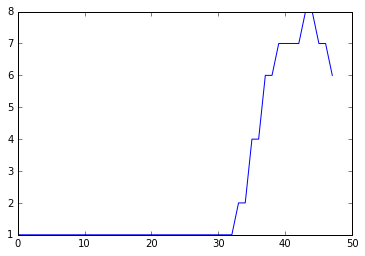

Nuit


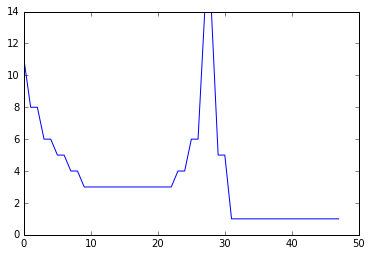

RENAULT


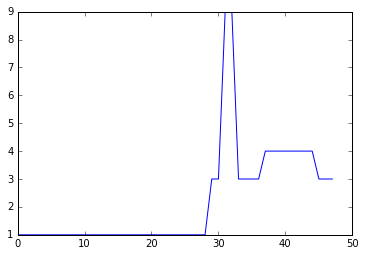

Regulation Medicale


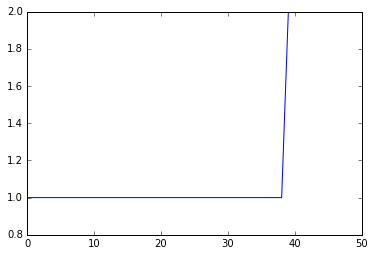

SAP


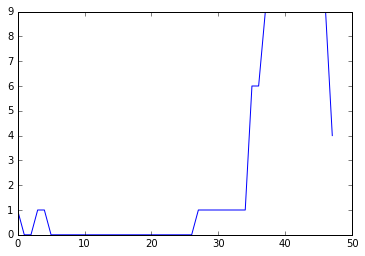

Services


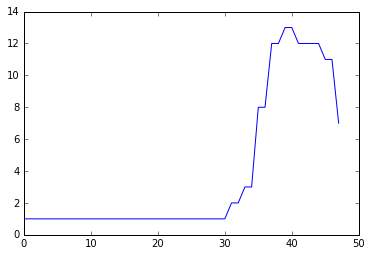

Tech. Axa


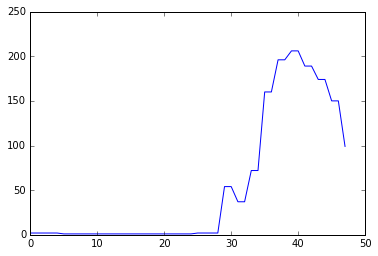

Tech. Inter


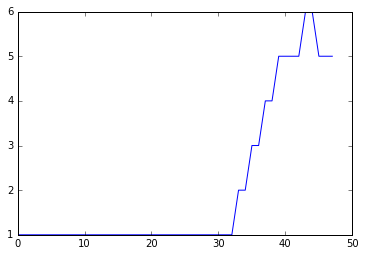

Téléphonie


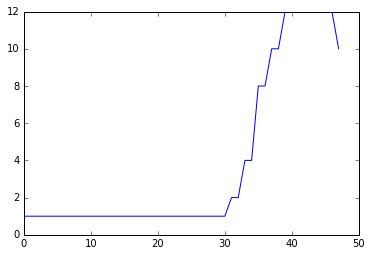

Tech. Total


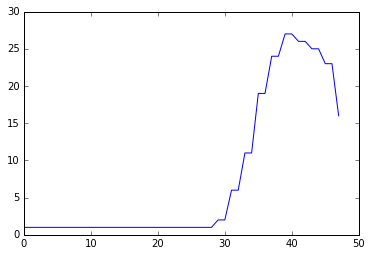

Mécanicien


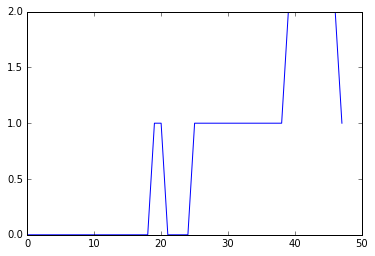

CAT


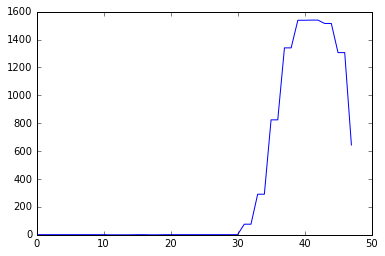

Manager


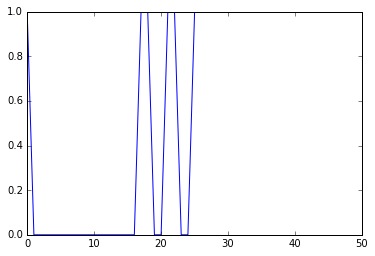

Gestion Clients


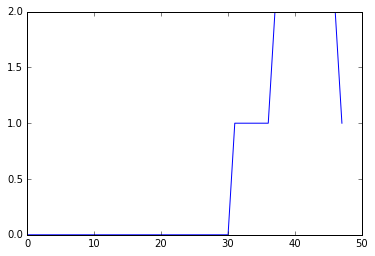

Gestion DZ


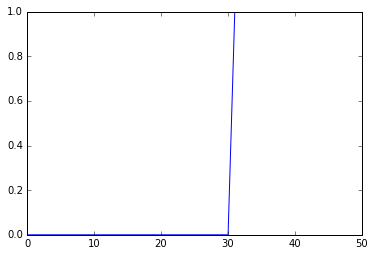

RTC


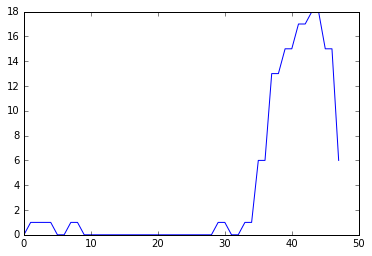

Prestataires


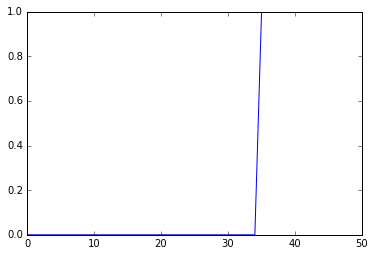

In [26]:
# Plot predictions for a 24 day for each service
#predicted_plot = predict(dates_to_datetime(['2011-12-28']))
for x in ass_list : 
    # Plot prediction
    print(x)
    plt.plot(range(len(predicted_plot[x])),predicted_plot[x][:,1])
    # Plot also actual data on day of 2011-12-28
    #df=pd.DataFrame(data[x])
    #df.columns=["Timestamp","Calls","Weekday","Month","Hour"]
    #plt.plot(df["Hour"][df["Timestamp"].strftime("%Y-%m-%d")=='2011-12-28'],df["Calls"][df["Timestamp"].strftime("%Y-%m-%d")=='2011-12-28'])
    plt.show()